In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy.random as npr


In [2]:
data = pd.read_csv("rate3.csv")

data['DATE'] = pd.to_datetime(data['DATE'],format='%d/%m/%Y')
data.head()


,DATE,DTB3
0,1954-01-04,1.33
1,1954-01-05,1.28
2,1954-01-06,1.28
3,1954-01-07,1.31
4,1954-01-08,1.31


In [3]:
def model_calibration(data):

    rate = data["DTB3"].values
    #transfrom rate that <= 0 to 0.0001 te prevent neg value and zero division
    rate = [0.0001 if item <= 0 else item for item in rate]      
    
    ols_y = [(y- x)/np.sqrt(x) for x, y in zip(rate, rate[1:])]
    ols_x1 = [1/np.sqrt(x) for x, y in zip(rate, rate[1:])]
    ols_x2 = [np.sqrt(x) for x, y in zip(rate, rate[1:])]

    df = data.drop(index=0, axis=0)
    df["ols_y"] = ols_y
    df["ols_x1"] = ols_x1
    df["ols_x2"] = ols_x2

    x = df[['ols_x1','ols_x2']]
    y = df['ols_y']

    model = sm.OLS(y, x).fit()
    ab = model.params[0]
    minus_a = model.params[1]
    a = -minus_a
    b = ab/a
    sigma = np.sqrt(model.scale)
    return a,b,sigma

In [6]:
def CIR_euler(kappa,theta,sigma,M,I,r0):
    dt= 1/M
    rh = np.zeros((M + 1, I))
    r = np.zeros_like(rh)
    rh[0] = r0
    r[0] = r0
    for t in range(1, M + 1):
        rh[t] = (rh[t - 1] +
                 kappa * (theta - np.maximum(rh[t - 1], 0)) * dt +
                 sigma * np.sqrt(np.maximum(rh[t - 1], 0)) *
                 math.sqrt(dt) * npr.standard_normal(I))  
    r = np.maximum(rh, 0)
    return r


In [7]:
def CIR_exact(kappa,theta,sigma,M,I,r0):
    dt = 1/M
    x = np.zeros((M+1,I))
    x[0] = r0
    for t in range(1, M+1):
        df = 4*theta*kappa / sigma**2
        c = (sigma ** 2 * (1- np.exp(-kappa * dt))) / (4 * kappa)
        nc = np.exp(-kappa*dt)/c*x[t-1]
        x[t] = c*npr.noncentral_chisquare(df,nc,size=I)
    return x


In [9]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2021-01-01', end='2023-08-02')
holidays_date = list(holidays.strftime('%Y-%m-%d'))

In [10]:
data_start_date = "2021-01-01"
data_end_date = "2022-06-01" #On 1st Rolling Window 

sim_start_date = "2022-06-01"
sim_end_date = "2023-08-02"

#get indexes of 1st Rolling Window
data_start_index = data.index[data['DATE']>=data_start_date].tolist()[0]
data_end_index = data.index[data['DATE']<data_end_date].tolist()[-1]

no_of_backtesting_days = np.busday_count("2022-06-01", "2022-11-01",holidays = holidays_date) 
no_of_backtesting_days

105

In [11]:
dates = []
estimated_r = []
for i in range(no_of_backtesting_days+1):
    
    segmented_data = data.iloc[data_start_index+i:data_end_index+1+i]
    segmented_data = segmented_data.reset_index(drop=True)
    a,b,sigma = model_calibration(segmented_data)
    
    t0 = data.iloc[data_end_index+i]["DATE"]
    r0 = data.iloc[data_end_index+i]["DTB3"]
    print(t0,r0)
    I = 10000
    M = np.busday_count(t0.date(), sim_end_date,holidays = holidays_date)
    r = CIR_euler(a,b,sigma,M,I,r0)
    mean_r = np.mean(r, axis=1)
    mean_r_without_r0 = np.delete(mean_r,0)
    estimated_r.append(np.mean(mean_r_without_r0))
    dates.append(data.iloc[data_end_index+i+1]["DATE"])

2022-05-31 00:00:00 1.13
2022-06-01 00:00:00 1.12
2022-06-02 00:00:00 1.13
2022-06-03 00:00:00 1.17
2022-06-06 00:00:00 1.23
2022-06-07 00:00:00 1.24
2022-06-08 00:00:00 1.25
2022-06-09 00:00:00 1.26
2022-06-10 00:00:00 1.34
2022-06-13 00:00:00 1.69
2022-06-14 00:00:00 1.78
2022-06-15 00:00:00 1.69
2022-06-16 00:00:00 1.54
2022-06-17 00:00:00 1.58
2022-06-21 00:00:00 1.66
2022-06-22 00:00:00 1.57
2022-06-23 00:00:00 1.59
2022-06-24 00:00:00 1.66
2022-06-27 00:00:00 1.75
2022-06-28 00:00:00 1.75
2022-06-29 00:00:00 1.73
2022-06-30 00:00:00 1.66
2022-07-01 00:00:00 1.66
2022-07-05 00:00:00 1.86
2022-07-06 00:00:00 1.85
2022-07-07 00:00:00 1.89
2022-07-08 00:00:00 1.91
2022-07-11 00:00:00 2.13
2022-07-12 00:00:00 2.16
2022-07-13 00:00:00 2.33
2022-07-14 00:00:00 2.33
2022-07-15 00:00:00 2.29
2022-07-18 00:00:00 2.44
2022-07-19 00:00:00 2.46
2022-07-20 00:00:00 2.44
2022-07-21 00:00:00 2.4
2022-07-22 00:00:00 2.41
2022-07-25 00:00:00 2.55
2022-07-26 00:00:00 2.48
2022-07-27 00:00:00 2.37
2

In [12]:
d = {'Date': dates , 'rate': estimated_r}
df = pd.DataFrame(data=d)
df.tail()

holidays_dates = cal.holidays(start='2022-06-01', end='2022-11-01')
temp = np.empty((len(holidays_dates)))
temp[:] = np.nan

d2 = {'Date': holidays_dates , 'rate':temp }
df2 = pd.DataFrame(data=d2)

frames = [df, df2]
result = pd.concat(frames)
result['Date'] = pd.to_datetime(result['Date'],format='%Y-%m-%d')
sort_df = result.sort_values(by='Date')
sort_df.fillna(method="ffill",inplace=True)
sort_df

,Date,rate
0,2022-06-01,1.135751
1,2022-06-02,1.125867
2,2022-06-03,1.135354
3,2022-06-06,1.175594
4,2022-06-07,1.237412
...,...,...
101,2022-10-26,3.992408
102,2022-10-27,3.962216
103,2022-10-28,3.971711
104,2022-10-31,4.012007


Text(0, 0.5, 'rate')

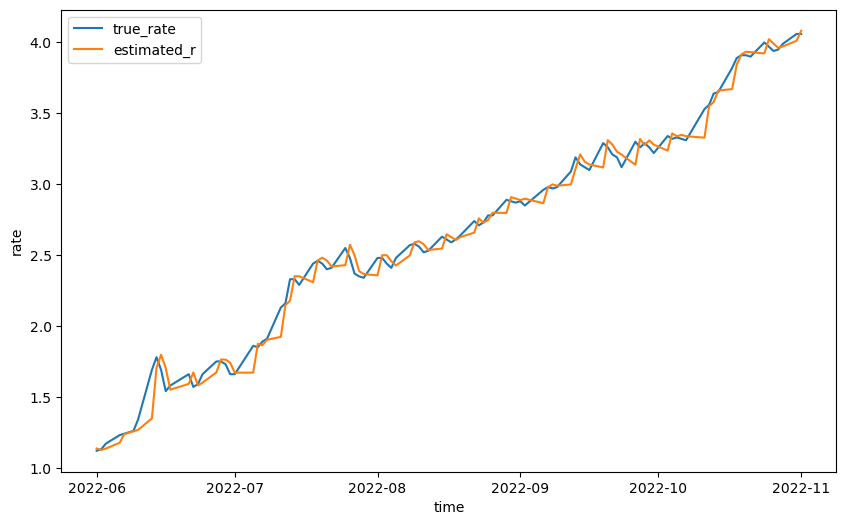

In [13]:
true_rate_data = pd.DataFrame(data[(data["DATE"] <= "2022-11-01") & (data["DATE"] >= "2022-06-01")])
true_rate_data["estimated_r"] = estimated_r
plt.figure(figsize=(10,6))
plt.plot(true_rate_data.DATE,true_rate_data.DTB3 ,label = "true_rate")
plt.plot(true_rate_data.DATE,true_rate_data.estimated_r , label = "estimated_r")
plt.legend()
plt.xlabel("time")
plt.ylabel("rate")

In [245]:
"""df.to_csv("interest_rate_woh.csv",index=False)
sort_df.to_csv("interest_rate_wh.csv",index=False)"""